In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py

import os
from dotenv import load_dotenv
load_dotenv()

from data_manipulation.reading_util import filter_unwanted_seqs

2023-08-26 00:59:52.399083: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-26 00:59:52.437487: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-26 00:59:52.438139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 00:59:53.508531: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Reading in esm2 embeddings

In [2]:
esm2_enzymes_30 = os.getenv("ESM2_ENZYMES_SPLIT_30")
esm2_non_enzymes = os.getenv("ESM2_NON_ENZYMES")

In [3]:
def get_ec_labels(path_to_enzyme_esm2: str, path_to_enzyme_splitX_csv) -> pd.DataFrame:
    """
    Adds a label representing the first main ec class (1-7) based on the ec number
    :param path_to_esm2: Absolute path to esm2 file
    :param path_to_enzyme_splitX_csv: Absolute path to splitX csv, which is needed for labeling
    :return: A dataframe containing the corresponding labels
    """
    with h5py.File(path_to_enzyme_esm2) as hdf_handle:
        headers = []
        embeddings = []

        for header, emb in hdf_handle.items():
            headers.append(header)
            embeddings.append(np.array(list(emb)))

    enzyme_csv = pd.read_csv(path_to_enzyme_splitX_csv, header=0, sep=',')
    # TODO: Inorder to apply this line of code, I also have to find the corresponding embeddings and 
    #  drop these as well...
    # enzyme_csv = filter_unwanted_seqs(enzyme_csv, True)
    
    print(len(embeddings))
    print(len(enzyme_csv)) 
    
    labels = {} # dict with → header(id): label (1-7)


    for header in headers:
        number = enzyme_csv.loc[enzyme_csv["Entry"] == header,"EC number"]
        ec = int(number.iat[0][0])-1 # since we always start counting from 0
        labels[header] = ec
    
    header_label_tuples = [(header, labels[header]) for header in headers]

    # Create a new list of embeddings with labels
    embeddings_with_labels = []

    for header, emb in zip(headers, embeddings):
        label = next((label for h, label in header_label_tuples if h == header), None)
        if label is not None:
            embeddings_with_labels.append((header, label, emb))
    
    return embeddings_with_labels


### Creating X and y

In [4]:
enzyme_csv = os.getenv("CSV50_ENZYMES")
esm2_enzymes = os.getenv("ESM2_ENZYMES_SPLIT_50")

labels = get_ec_labels(path_to_enzyme_esm2=esm2_enzymes, path_to_enzyme_splitX_csv=enzyme_csv)

X = []
y = []
for entry in labels:
    y.append(entry[1]) # append label (1-7)
    X.append(entry[2]) # append embedding

28788
28788


28788
28788


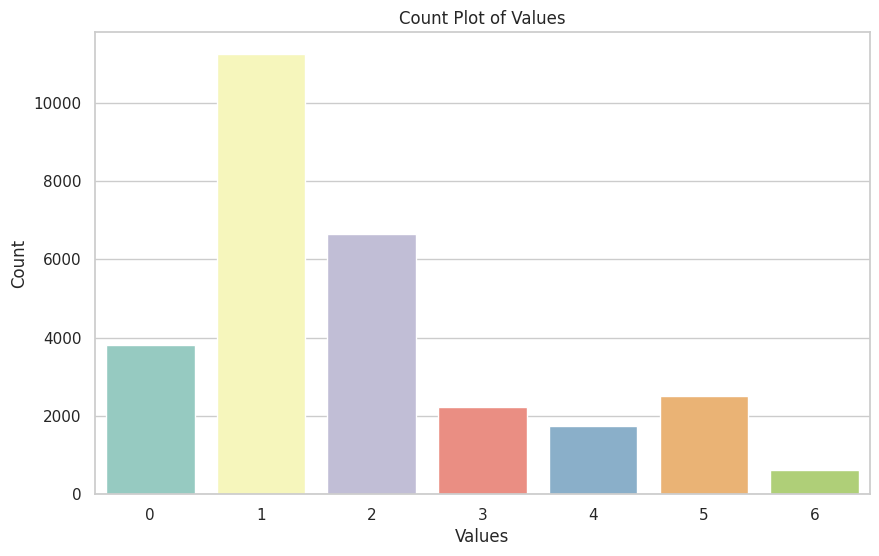

In [5]:

print(len(X))
print(len(y))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y, palette="Set3")

# Add labels and title
plt.xlabel("Values")
plt.ylabel("Count")
plt.title("Count Plot of Values")

# Show the plot
plt.show()

In [6]:
# Create a DataFrame
df = pd.DataFrame({"feature1":X, "label":y})


# Convert the lists in 'feature1' into separate columns using pd.DataFrame constructor
feature_columns = pd.DataFrame(df["feature1"].tolist(), columns=[f"feature_{i+1}" for i in range(2560)])

# Concatenate the feature columns with the original DataFrame
df = pd.concat([df.drop("feature1", axis=1), feature_columns], axis=1)

# Display the resulting DataFrame
print(df.head())


   label  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0      0  -0.053399   0.026311   0.068040  -0.047504  -0.056120   0.021154   
1      2  -0.015143   0.035552  -0.022313   0.002838  -0.011048  -0.017585   
2      0   0.059097  -0.034141   0.061427   0.006349  -0.058036  -0.020592   
3      3  -0.014913  -0.010767  -0.010989  -0.013517   0.011791  -0.016675   
4      1  -0.036617  -0.003793   0.057039  -0.080738  -0.038742  -0.017655   

   feature_7  feature_8  feature_9  ...  feature_2551  feature_2552  \
0  -0.073030   0.139663   0.022752  ...      0.032434     -0.056128   
1  -0.095678   0.095675   0.048721  ...     -0.021529     -0.027920   
2  -0.064093   0.100112   0.019740  ...      0.089701     -0.076780   
3   0.032285  -0.010640   0.050260  ...      0.057059     -0.018963   
4  -0.071962   0.214017   0.095484  ...      0.000637      0.039427   

   feature_2553  feature_2554  feature_2555  feature_2556  feature_2557  \
0     -0.047019      0.024053

In [7]:

X = df.drop('label', axis=1).values
y = df['label'].values



In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)


In [9]:
scaler = MinMaxScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)


In [10]:
len(X_train[0])

2560

In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=7, activation='softmax'))  # Using softmax for multi-class classification
# model.add(
#     tf.keras.layers.Dense(units=2560, activation="relu", input_shape=(2560,))
# )
# 
# model.add(
#     tf.keras.layers.Dense(units=15, activation="relu")
# )
# 
# model.add(
#     tf.keras.layers.Dense(units=7, activation='softmax') # da classification
# )

model.compile(loss='categorical_crossentropy', optimizer='adam')


In [12]:
model.fit(x=X_train, y=y_train_encoded, epochs=200, validation_data=(X_test, y_test_encoded))

Epoch 1/200
603/603 [==============================] - 7s 11ms/step - loss: 0.8811 - val_loss: 1.3392
Epoch 2/200
603/603 [==============================] - 7s 11ms/step - loss: 0.3718 - val_loss: 1.0096
Epoch 3/200
603/603 [==============================] - 7s 11ms/step - loss: 0.2677 - val_loss: 1.2834
Epoch 4/200
603/603 [==============================] - 7s 11ms/step - loss: 0.2140 - val_loss: 3.0472
Epoch 5/200
603/603 [==============================] - 7s 11ms/step - loss: 0.1696 - val_loss: 6.9762
Epoch 6/200
603/603 [==============================] - 6s 11ms/step - loss: 0.1426 - val_loss: 4.8682
Epoch 7/200
603/603 [==============================] - 7s 11ms/step - loss: 0.1248 - val_loss: 10.9757
Epoch 8/200
603/603 [==============================] - 7s 11ms/step - loss: 0.1105 - val_loss: 9.4495
Epoch 9/200
603/603 [==============================] - 6s 11ms/step - loss: 0.0971 - val_loss: 14.4813
Epoch 10/200
603/603 [==============================] - 7s 11ms/step - loss: 0.0

<Axes: >

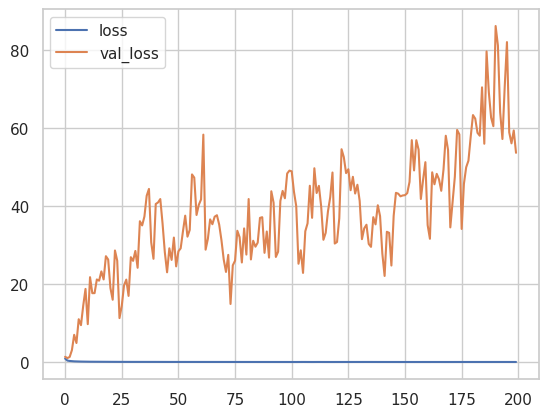

In [13]:
model_loss = pd.DataFrame(model.history.history)

model_loss.plot() # early stopping where plot diverges


In [14]:
predictions = np.argmax(model.predict(X_test), axis=-1) # for multi class classification (using softmax)

297/297 [==============================] - 1s 2ms/step


In [15]:
counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print(counter)
print(len(y_test))

5476
9501


In [16]:
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.94      0.43      0.59      1275
           1       0.48      1.00      0.65      3656
           2       0.99      0.33      0.49      2245
           3       0.76      0.37      0.50       714
           4       0.99      0.14      0.24       599
           5       1.00      0.14      0.25       774
           6       1.00      0.32      0.49       238

    accuracy                           0.58      9501
   macro avg       0.88      0.39      0.46      9501
weighted avg       0.77      0.58      0.53      9501


In [17]:
print(confusion_matrix(y_test, predictions))


[[ 552  708    3   11    1    0    0]
 [   1 3648    5    2    0    0    0]
 [  13 1437  739   56    0    0    0]
 [   8  438    2  266    0    0    0]
 [   3  498    0   15   83    0    0]
 [   0  662    0    1    0  111    0]
 [   8  152    0    1    0    0   77]]


In [18]:
model.save("initial_ann_v1_50")

INFO:tensorflow:Assets written to: initial_ann_v1_50/assets


INFO:tensorflow:Assets written to: initial_ann_v1_50/assets
